In [232]:
#Importing the libraries necessary to build the models and do the hypertuning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from sklearn.svm import SVC
from sklearn.metrics import f1_score, mean_absolute_error 
from plotnine import *
import os
import datetime
import pickle
import json
#from scikeras.wrappers import KerasClassifier --> Does not work?
import tensorflow as tf
# Libraries and options
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
import IPython


In [188]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [189]:
#Import the dataset that is cleaned in the EDA
os.chdir('/users/donnajenkins/desktop')
funda = pd.read_csv('output.csv')
funda['id'] = funda.groupby(['url'], sort=False).ngroup() + 1
funda.head()

,Unnamed: 0,city,Provincienaam,url,title,price,postalcode,livingspace,plotarea,constructionyear,...,rooms,bathroom,description,offerdate,selldate,duration,broker,garden_bool,constructionyear_category,id
0,0,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Oosteinderweg 373,335000,1432 AZ,116,195,1930,...,3,1,LET OP: WEGENS DE GROTE BELANGSTELLING IS HET ...,11 augustus 2021,11 oktober 2021,2 maanden,Makelaarskantoor Mantel BV,False,Between 1900-1950,1
1,1,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/ap...,Koolwitjestraat 201,350000,1432 NT,85,1,2005,...,2,1,Comfortabel en ruim 2-kamer appartement met tu...,NaN,NaN,NaN,NaN,True,Between 2000-2010,2
2,2,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Legmeerdijk 241,875000,1432 KB,153,1,1957,...,5,2,ENGLISH SUMMARY BELOW Heerlijk vrij wonen omri...,NaN,NaN,NaN,NaN,True,Between 1950-2000,3
3,3,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Wissel 37,425000,1431 LN,130,129,1988,...,6,1,Woningzoekers opgelet! Wij hebben een unieke k...,NaN,NaN,NaN,NaN,True,Between 1950-2000,4
4,4,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Oosteinderweg 454,1425000,1432 BP,219,1,1989,...,5,2,Is deze fraaie vrijstaande villa met geweldige...,NaN,NaN,NaN,NaN,True,Between 1950-2000,5


In [190]:
#Converting energylabel to 3 classes
funda['energylabel'] = funda['energylabel'].replace(['A+', 'A++','A+++', 'A++++','A+++++' ,'A' ], 'high')
funda['energylabel'] = funda['energylabel'].replace(['B','C','D'] , 'middle')
funda['energylabel'] = funda['energylabel'].replace(['E','F','G'] , 'low')

In [191]:
#Converting the housetypes into 7 different classes to narrow the amount of columns down when modelling
funda['housetype'] = pd.np.where(funda.housetype.str.contains("Eengezinswoning|eengezinswoning"), "Eengezinswoning",
    pd.np.where(funda.housetype.str.contains("appartement"), "Appartement",
    pd.np.where(funda.housetype.str.contains("Villa"), "Villa",
    pd.np.where(funda.housetype.str.contains("Herenhuis"), "Herenhuis",
    pd.np.where(funda.housetype.str.contains("Portiekflat"), "Portiekflat",
    pd.np.where(funda.housetype.str.contains("Bungalow"), "Bungalow", "Other"))))))

<ipython-input-191-0b3473331c3f>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
<ipython-input-191-0b3473331c3f>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
<ipython-input-191-0b3473331c3f>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
<ipython-input-191-0b3473331c3f>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
<ipython-input-191-0b3473331c3f>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
<ipython-input-191-0b3473331c3f>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy dir

In [192]:
# See the results of the classifications

funda.head()

,Unnamed: 0,city,Provincienaam,url,title,price,postalcode,livingspace,plotarea,constructionyear,...,rooms,bathroom,description,offerdate,selldate,duration,broker,garden_bool,constructionyear_category,id
0,0,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Oosteinderweg 373,335000,1432 AZ,116,195,1930,...,3,1,LET OP: WEGENS DE GROTE BELANGSTELLING IS HET ...,11 augustus 2021,11 oktober 2021,2 maanden,Makelaarskantoor Mantel BV,False,Between 1900-1950,1
1,1,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/ap...,Koolwitjestraat 201,350000,1432 NT,85,1,2005,...,2,1,Comfortabel en ruim 2-kamer appartement met tu...,NaN,NaN,NaN,NaN,True,Between 2000-2010,2
2,2,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Legmeerdijk 241,875000,1432 KB,153,1,1957,...,5,2,ENGLISH SUMMARY BELOW Heerlijk vrij wonen omri...,NaN,NaN,NaN,NaN,True,Between 1950-2000,3
3,3,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Wissel 37,425000,1431 LN,130,129,1988,...,6,1,Woningzoekers opgelet! Wij hebben een unieke k...,NaN,NaN,NaN,NaN,True,Between 1950-2000,4
4,4,Aalsmeer,Noord-Holland,https://www.funda.nl/koop/verkocht/aalsmeer/hu...,Oosteinderweg 454,1425000,1432 BP,219,1,1989,...,5,2,Is deze fraaie vrijstaande villa met geweldige...,NaN,NaN,NaN,NaN,True,Between 1950-2000,5


In [193]:
#Dropping the collums that are not going to be used for the models
funda.drop('Unnamed: 0', inplace=True, axis=1)
funda.drop('title', inplace=True, axis=1)
funda.drop('postalcode', inplace=True, axis=1)
funda.drop('city', inplace=True, axis=1)
funda.drop('constructionyear', inplace=True, axis=1)
#funda.drop('energylabel', inplace=True, axis=1)
funda.drop('bathroom', inplace=True, axis=1)
funda.drop('description', inplace=True, axis=1)
funda.drop('offerdate', inplace=True, axis=1)
funda.drop('selldate', inplace=True, axis=1)
funda.drop('duration', inplace=True, axis=1)
funda.drop('broker', inplace=True, axis=1)
funda.drop('garden', inplace=True, axis=1)


In [194]:
#Dropping the url
funda.drop('url', inplace=True, axis=1)

In [195]:
#See the result of the smaller dataset that is going to be used for the modelling
funda.head()

,Provincienaam,price,livingspace,plotarea,energylabel,housetype,rooms,garden_bool,constructionyear_category,id
0,Noord-Holland,335000,116,195,low,Eengezinswoning,3,False,Between 1900-1950,1
1,Noord-Holland,350000,85,1,middle,Other,2,True,Between 2000-2010,2
2,Noord-Holland,875000,153,1,low,Eengezinswoning,5,True,Between 1950-2000,3
3,Noord-Holland,425000,130,129,high,Eengezinswoning,6,True,Between 1950-2000,4
4,Noord-Holland,1425000,219,1,middle,Villa,5,True,Between 1950-2000,5


In [196]:
#Check for missing valuea
funda.isnull().sum()

Provincienaam                0
price                        0
livingspace                  0
plotarea                     0
energylabel                  0
housetype                    0
rooms                        0
garden_bool                  0
constructionyear_category    0
id                           0
dtype: int64

In [197]:
#If there were missing values the code below can be used
#funda.fillna(funda.mean())

## Creating train test and validation splits

We split the dataset into train, validation, and test
We will set test aside, which will be used to evaluate the final performance of the model. Then we will use train and validation to fit the actual model.

The reason why we split the data into train, validation, and test is that we want to train the model and then evaluate the model accuracy on data that the model has never seen. This is the only way to accurately evaluate the predictive performance of a model.

If there is enough data, the following algorithm to split into train/validation/test is a good one:
split the dataset into fitting data (80%) and test set (20%)
split the fitting data further into train set (80% of the fitting data) and validation set (20% of the fitting data)
If there is not enough data, then crossvalidation is the only option in order to find the best model parameters

In [198]:

class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed
    
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            default_count = (getattr(self, i))
            n_high_price = default_count.loc[default_count['price'] > 500000].shape[0]
            n_low_price = default_count.loc[default_count['price'] < 100000].shape[0]
            split_stats['percentage_high_Price'] = split_stats['Percentage_high_price'] = n_high_price/self.total_high_Price * 100
            split_stats['percentage_low_Price'] = split_stats['Percentage_low_price'] = n_low_price/self.total_high_Price * 100
            statistics[i] = split_stats
        self.split_statistics = statistics

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_high_Price = df.loc[df['price'] > 500000].shape[0]
        self.total_low_Price = df.loc[df['price'] < 100000].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [199]:
fitting_splits = TrainTestSplitter()

In [200]:
fitting_splits.split_train_test(funda)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [201]:
fitting_splits.test_set.shape

(20345, 10)

In [202]:
#See the result of splitting the dataset
fitting_splits.split_statistics

{'train_set': {'percentage_high_Price': 63.932702418506835,
  'Percentage_high_price': 63.932702418506835,
  'percentage_low_Price': 0.1892744479495268,
  'Percentage_low_price': 0.1892744479495268},
 'test_set': {'percentage_high_Price': 20.047318611987382,
  'Percentage_high_price': 20.047318611987382,
  'percentage_low_Price': 0.05783385909568874,
  'Percentage_low_price': 0.05783385909568874},
 'validation_set': {'percentage_high_Price': 16.019978969505782,
  'Percentage_high_price': 16.019978969505782,
  'percentage_low_Price': 0.0473186119873817,
  'Percentage_low_price': 0.0473186119873817}}

# Dummification and scaling

Before fitting a model to our data, we need to deal with two data transformations that are essential to be able to obtain a performant model. These are dummification or one-hot-encoding and scaling.


In [48]:
#Use the hotencoder to transform the columns that need to be transformed.
one_hot_encoder = OneHotEncoder() # one hot encoder is a class instance
one_hot_encoder.fit(fitting_splits.train_set[[ 'energylabel' , 'constructionyear_category','Provincienaam', 'garden_bool', 'housetype']]) # we can fit the encoder instance on the columns that need to be transformed.

OneHotEncoder()

In [49]:
# let's check what the encoder did
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names() # with this method we can retrieve the names of the new dummy columns that have been computed
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[[ 'energylabel' , 'constructionyear_category', 'Provincienaam', 'garden_bool', 'housetype']]).toarray() # at this point, we can use the fitted encoder to transform any array with column; not just the training set, but also the validation or test set. The encoder will take that array of shape (M,2) and transform it to an array of shape (M, N), where N is the total number of distinct possible values for the encoded features. The values of the new array will be either 0 or 1, encoding whether that value of the feature applies to the row.
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['high', 'low', 'middle'], dtype=object),
 array(['After 2010', 'Before 1600', 'Between 1600-1700',
        'Between 1700-1800', 'Between 1800-1900', 'Between 1900-1950',
        'Between 1950-2000', 'Between 2000-2010'], dtype=object),
 array(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen',
        'Limburg', 'Noord-Brabant', 'Noord-Holland', 'Overijssel',
        'Utrecht', 'Zeeland', 'Zuid-Holland'], dtype=object),
 array([False,  True]),
 array(['Appartement', 'Bungalow', 'Eengezinswoning', 'Herenhuis', 'Other',
        'Portiekflat', 'Villa'], dtype=object)]

array(['x0_high', 'x0_low', 'x0_middle', 'x1_After 2010',
       'x1_Before 1600', 'x1_Between 1600-1700', 'x1_Between 1700-1800',
       'x1_Between 1800-1900', 'x1_Between 1900-1950',
       'x1_Between 1950-2000', 'x1_Between 2000-2010', 'x2_Drenthe',
       'x2_Flevoland', 'x2_Friesland', 'x2_Gelderland', 'x2_Groningen',
       'x2_Limburg', 'x2_Noord-Brabant', 'x2_Noord-Holland',
       'x2_Overijssel', 'x2_Utrecht', 'x2_Zeeland', 'x2_Zuid-Holland',
       'x3_False', 'x3_True', 'x4_Appartement', 'x4_Bungalow',
       'x4_Eengezinswoning', 'x4_Herenhuis', 'x4_Other', 'x4_Portiekflat',
       'x4_Villa'], dtype=object)

,x0_high,x0_low,x0_middle,x1_After 2010,x1_Before 1600,x1_Between 1600-1700,x1_Between 1700-1800,x1_Between 1800-1900,x1_Between 1900-1950,x1_Between 1950-2000,...,x2_Zuid-Holland,x3_False,x3_True,x4_Appartement,x4_Bungalow,x4_Eengezinswoning,x4_Herenhuis,x4_Other,x4_Portiekflat,x4_Villa
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65099,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65100,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65102,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
# after we have generated the dummy columns, we want to drop the original columns from the training data, and replace them with the dummy columns
train_set = fitting_splits.train_set.drop([ 'energylabel' , 'constructionyear_category', 'Provincienaam', 'garden_bool', 'housetype'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,price,livingspace,plotarea,rooms,id,x0_high,x0_low,x0_middle,x1_After 2010,x1_Before 1600,...,x2_Zuid-Holland,x3_False,x3_True,x4_Appartement,x4_Bungalow,x4_Eengezinswoning,x4_Herenhuis,x4_Other,x4_Portiekflat,x4_Villa
0,375000,129,121,5,96559,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,390000,102,112,4,58261,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,189500,95,360,5,88863,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,700000,107,3,4,7764,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,265000,83,258,3,78594,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65099,550000,167,345,6,100885,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65100,275000,128,140,5,64005,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65101,345000,147,161,5,17872,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65102,244500,99,152,5,95365,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [51]:
# now we fit the StandardScaler, in order to standardize all the features
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)
# the above standard scaler, when apply to a dataset with the same columns as the train set, will scale all the numerical features and return a numpy array
standard_scaler.transform(train_set)

StandardScaler()

array([[-0.08944401,  0.30367699, -0.12430171, ..., -0.24698109,
        -0.1480828 , -0.15928866],
       [-0.02756883, -0.26641522, -0.17983923, ..., -0.24698109,
        -0.1480828 , -0.15928866],
       [-0.8546338 , -0.41421691,  1.350528  , ..., -0.24698109,
        -0.1480828 , -0.15928866],
       ...,
       [-0.21319438,  0.68373847,  0.12253171, ..., -0.24698109,
        -0.1480828 , -0.15928866],
       [-0.62775812, -0.3297588 ,  0.06699419, ..., -0.24698109,
        -0.1480828 , -0.15928866],
       [ 0.67368327,  1.12714353,  1.91824488, ..., -0.24698109,
        -0.1480828 , -0.15928866]])

In [52]:
class DataPreparer(object):
    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = ['energylabel' , 'constructionyear_category', 'Provincienaam', 'garden_bool', 'housetype']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names()
        # add the encoded columns and drop the original columns
        df = df.drop(vars_to_encode,axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        # first dummify the data
        df = self.dummify(df)
        # then scale it
        df = self.scale(df)
        return df

In [53]:
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
data_preparer.prepare_data(fitting_splits.train_set).head()
data_preparer.prepare_data(fitting_splits.validation_set).head()

,price,livingspace,plotarea,rooms,id,x0_high,x0_low,x0_middle,x1_After 2010,x1_Before 1600,...,x2_Zuid-Holland,x3_False,x3_True,x4_Appartement,x4_Bungalow,x4_Eengezinswoning,x4_Herenhuis,x4_Other,x4_Portiekflat,x4_Villa
0,-0.089444,0.303677,-0.124302,0.393661,1.552356,1.800822,-0.575269,-1.031841,2.860962,-0.019204,...,-0.496306,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
1,-0.027569,-0.266415,-0.179839,-0.296122,0.249185,-0.555302,1.738317,-1.031841,-0.349533,-0.019204,...,2.014886,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
2,-0.854634,-0.414217,1.350528,0.393661,1.290484,-0.555302,1.738317,-1.031841,-0.349533,-0.019204,...,-0.496306,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
3,1.251185,-0.160843,-0.852460,-0.296122,-1.469083,-0.555302,1.738317,-1.031841,-0.349533,-0.019204,...,-0.496306,1.588318,-1.588318,1.612479,-0.117527,-1.160029,-0.179537,-0.246981,-0.148083,-0.159289
4,-0.543195,-0.667591,0.721103,-0.985905,0.941059,-0.555302,-0.575269,0.969141,-0.349533,-0.019204,...,-0.496306,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289


,price,livingspace,plotarea,rooms,id,x0_high,x0_low,x0_middle,x1_After 2010,x1_Before 1600,...,x2_Zuid-Holland,x3_False,x3_True,x4_Appartement,x4_Bungalow,x4_Eengezinswoning,x4_Herenhuis,x4_Other,x4_Portiekflat,x4_Villa
0,0.611808,1.127144,0.178069,1.773226,1.474366,-0.555302,-0.575269,0.969141,-0.349533,-0.019204,...,2.014886,-0.629597,0.629597,-0.620163,-0.117527,-1.160029,5.569884,-0.246981,-0.148083,-0.159289
1,0.587058,0.662624,-0.093448,0.393661,0.793415,1.800822,-0.575269,-1.031841,-0.349533,-0.019204,...,2.014886,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
2,-0.689633,-0.794278,-0.013227,-0.296122,-1.719794,-0.555302,-0.575269,0.969141,-0.349533,-0.019204,...,2.014886,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
3,0.504558,0.240333,-0.025568,0.393661,-0.214672,-0.555302,1.738317,-1.031841,-0.349533,-0.019204,...,-0.496306,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289
4,-0.316320,0.641509,-0.253889,1.083443,1.380587,-0.555302,-0.575269,0.969141,-0.349533,-0.019204,...,2.014886,-0.629597,0.629597,-0.620163,-0.117527,0.862047,-0.179537,-0.246981,-0.148083,-0.159289


# Modeling with the Random Forest model

In this part of the notebook the random forest model will be used to predrict the houseprices. The model will be fitted, tuned and evaluated. 

In [77]:
# get the transformed train set
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['price', 'id'], axis=1) # need to drop the target! otherwise data leakage
y_train = fitting_splits.train_set['price'] # take it from the original untransformed dataset

X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['price', 'id'], axis=1)
y_validation = fitting_splits.validation_set['price']
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['price']])

# create the model instance
regr = RandomForestRegressor(n_estimators=20, min_samples_split=5)
# fit the model instance on X_train
RegFit = regr.fit(X=X_train, y=y_train.values.ravel())

In [78]:
# now we can use the fitted Random Forest model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['price', 'id'], axis=1)
y_test = fitting_splits.test_set['price']

y_hat_test = regr.predict(X_test)

# the result is a vector of predicted classes for the observations in validation, which the model was not trained on!
pd.Series(y_hat_test)

0        5.149580e+05
1        1.370871e+06
2        1.014870e+06
3        9.391554e+05
4        4.400208e+05
             ...     
20340    6.761190e+05
20341    2.116912e+05
20342    2.570190e+05
20343    3.073307e+05
20344    3.221346e+05
Length: 20345, dtype: float64

In [79]:
#See what the predicted set is
pd.Series(y_hat_test).describe()
fitting_splits.test_set['price'].describe()

count    2.034500e+04
mean     3.967934e+05
std      2.216970e+05
min      1.160311e+05
25%      2.695122e+05
50%      3.396094e+05
75%      4.524646e+05
max      4.216302e+06
dtype: float64

count    2.034500e+04
mean     3.969397e+05
std      2.478293e+05
min      3.500000e+04
25%      2.590000e+05
50%      3.350000e+05
75%      4.500000e+05
max      7.600000e+06
Name: price, dtype: float64

In [80]:
# some metrics from: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))

Mean Absolute Error: 70302.15827420905
Mean Squared Error: 16723961223.24377
Root Mean Squared Error: 129321.15535844772


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Random Forest Predictions')

Text(0, 0.5, 'True Values')

(0.0, 800000.0)

(0.0, 800000.0)

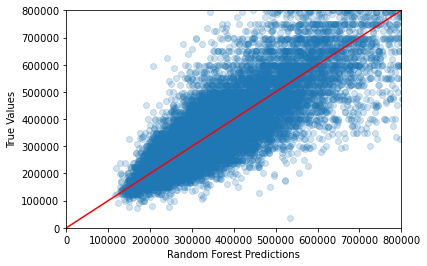

In [179]:
#Plotting the predictions over the true values
plt.figure()
plt.scatter(y_hat_test, y_test, alpha=0.2)
plt.xlabel('Random Forest Predictions')
plt.ylabel('True Values')
lims = [0, 800000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')
plt.show()

<Figure size 432x288 with 0 Axes>

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 5.000e+00,
        4.000e+00, 4.000e+00, 1.200e+01, 9.000e+00, 1.900e+01, 3.600e+01,
        4.400e+01, 1.030e+02, 2.940e+02, 8.070e+02, 3.181e+03, 9.711e+03,
        4.733e+03, 9.090e+02, 2.420e+02, 1.190e+02, 3.900e+01, 1.100e+01,
        1.900e+01, 8.000e+00, 5.000e+0

Text(0.5, 0, 'Absolute Prediction Error for Random Forest')

Text(0, 0.5, 'Count')

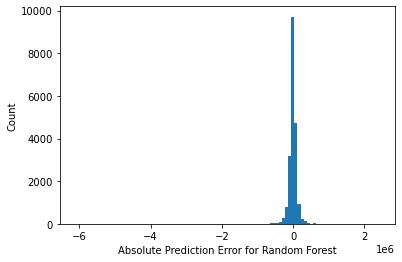

In [82]:
#See the error of the Random Forest model
error = y_hat_test - y_test
plt.figure()
plt.hist(error, bins = 100)
plt.xlabel("Absolute Prediction Error for Random Forest")
plt.ylabel("Count")
plt.show()

In [61]:
#R2-score for regression problem
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

predictions = regr.predict(X_test)

r2 = r2_score(y_test.values.ravel(), predictions)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.73


# Hypertuning

In [219]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [100,1000]
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]


In [220]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 177, 255, 333, 411, 488, 566, 644, 722, 800], 'max_features': ['auto'], 'max_depth': [100, 1000], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [True]}


In [221]:
rf_Model = RandomForestRegressor()

In [222]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [233]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True], 'max_depth': [100, 1000],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [100, 177, 255, 333, 411, 488, 566,
                                          644, 722, 800]},
             verbose=2)

In [234]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [235]:
#Test accuracy
print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.957
Test Accuracy - : 0.732


In [237]:
#R2 score for confirmation
predictions = rf_Grid.predict(X_train)

r2 = r2_score(y_train.values.ravel(), predictions)
print('R-squared scores:', round(r2,3))

R-squared scores: 0.957


# Modelling with neural networks

In this part of the notebook we are going to build a neural network model to predict the houseprice. 

In [129]:
#Printing version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

tensorflow: 2.7.0


In [130]:
#Printing version
import keras
print('keras: %s' % keras.__version__)

keras: 2.7.0


In [131]:
# import what we need from keras
from keras.models import Sequential
from keras.layers import Dense

In [132]:
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 35


In [137]:
#Build the model with 3 layers
from tensorflow.keras import layers
def build_NN_model():
    NN_model = Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    NN_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'accuracy'])
    return NN_model

In [138]:
#Summary of the model
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                2304      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [140]:
#try out model before training
example_batch = X_train [:10]
example_result = NN_model.predict(example_batch)
example_result

array([[485897.4 ],
       [346957.72],
       [232111.2 ],
       [637983.2 ],
       [346810.6 ],
       [274207.9 ],
       [463574.56],
       [394419.03],
       [412898.2 ],
       [358079.3 ]], dtype=float32)

In [141]:
#Fitting the model with 100 epochs and a batch size of 50. Also splitting a set of the data to validate it later in a plot. 
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split= 0.2)        

Epoch 1/100
1042/1042 [==============================] - 3s 3ms/step - loss: 17317652480.0000 - mean_absolute_error: 74843.3359 - accuracy: 0.0000e+00 - val_loss: 19922216960.0000 - val_mean_absolute_error: 74773.6406 - val_accuracy: 0.0000e+00
Epoch 2/100
1042/1042 [==============================] - 2s 2ms/step - loss: 17260113920.0000 - mean_absolute_error: 74754.4922 - accuracy: 0.0000e+00 - val_loss: 19861358592.0000 - val_mean_absolute_error: 74575.3594 - val_accuracy: 0.0000e+00
Epoch 3/100
1042/1042 [==============================] - 2s 2ms/step - loss: 17204062208.0000 - mean_absolute_error: 74656.0547 - accuracy: 0.0000e+00 - val_loss: 19811772416.0000 - val_mean_absolute_error: 74822.7188 - val_accuracy: 0.0000e+00
Epoch 4/100
1042/1042 [==============================] - 3s 2ms/step - loss: 17144215552.0000 - mean_absolute_error: 74627.2969 - accuracy: 0.0000e+00 - val_loss: 19749167104.0000 - val_mean_absolute_error: 74303.5312 - val_accuracy: 0.0000e+00
Epoch 5/100
1042/104

In [142]:
# Retrieve the hitory of every epoch's training
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,accuracy,val_loss,val_mean_absolute_error,val_accuracy,epoch
95,1.535917e+10,71243.343750,0.0,1.801752e+10,71418.109375,0.0,95
96,1.534916e+10,71236.195312,0.0,1.801161e+10,71342.515625,0.0,96
97,1.534249e+10,71237.007812,0.0,1.798948e+10,71367.117188,0.0,97
98,1.532527e+10,71181.101562,0.0,1.798472e+10,71485.710938,0.0,98
99,1.531957e+10,71181.210938,0.0,1.797778e+10,71331.398438,0.0,99


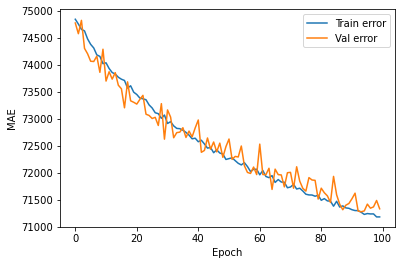

In [152]:
#Creating a plot to see the mean absolute error from the train and validation set. 
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label='Val error')
    plt.legend()
    #plt.ylim([0,5])

plot_history(history)

Epoch 1/1000
1628/1628 [==============================] - 6s 3ms/step - loss: 207044902912.0000 - mean_absolute_error: 388037.1875 - accuracy: 0.0000e+00 - val_loss: 185828130816.0000 - val_mean_absolute_error: 360448.1250 - val_accuracy: 0.0000e+00
Epoch 2/1000
1628/1628 [==============================] - 3s 2ms/step - loss: 120972386304.0000 - mean_absolute_error: 276236.0312 - accuracy: 0.0000e+00 - val_loss: 57735847936.0000 - val_mean_absolute_error: 159352.6719 - val_accuracy: 0.0000e+00
Epoch 3/1000
1628/1628 [==============================] - 3s 2ms/step - loss: 35492884480.0000 - mean_absolute_error: 121227.6562 - accuracy: 0.0000e+00 - val_loss: 32705513472.0000 - val_mean_absolute_error: 108325.3516 - val_accuracy: 0.0000e+00
Epoch 4/1000
1628/1628 [==============================] - 3s 2ms/step - loss: 26968344576.0000 - mean_absolute_error: 102160.5234 - accuracy: 0.0000e+00 - val_loss: 28231911424.0000 - val_mean_absolute_error: 97820.3828 - val_accuracy: 0.0000e+00
Epoch 

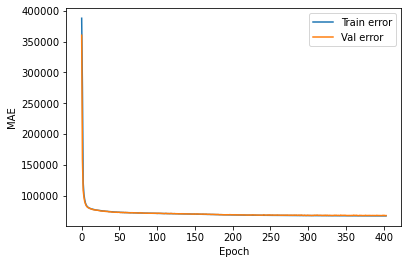

In [157]:
#use early stopping to make sure there is no overfitting
NN_model = build_NN_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience =10)

history = NN_model.fit(X_train, y_train, epochs = 1000,
                        validation_split= 0.2, callbacks =[early_stop])
plot_history(history)



In [158]:
#Evaluate the mean absolute error of the model
loss, mae, mse = NN_model.evaluate(X_train, y_train)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

2035/2035 [==============================] - 2s 1ms/step - loss: 13449242624.0000 - mean_absolute_error: 67005.9297 - accuracy: 0.0000e+00
Testing set Mean Abs Error: 67005.93 


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Predictions')

Text(0, 0.5, 'True Values')

(0.0, 800000.0)

(0.0, 800000.0)

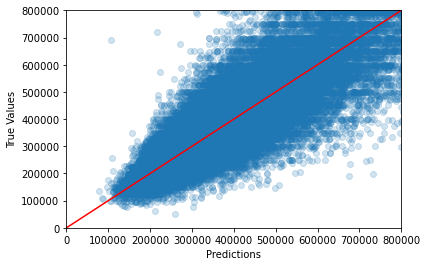

In [267]:
#Comparison of the predictions to the true values
test_predictions = NN_model.predict(X_train).flatten()
test_predictions1 = NN_model.predict(X_test).flatten()

plt.figure()
plt.scatter(test_predictions, y_train, alpha=0.2)
#plt.scatter(test_predictions1, y_test, alpha=0.2)
plt.xlabel('Predictions')
plt.ylabel('True Values')
lims = [0, 800000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')
plt.show()

(array([3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00,
        5.0000e+00, 4.0000e+00, 5.0000e+00, 9.0000e+00, 9.0000e+00,
        5.0000e+00, 1.1000e+01, 1.2000e+01, 2.0000e+01, 1.9000e+01,
        3.0000e+01, 4.5000e+01, 6.1000e+01, 7.2000e+01, 1.1800e+02,
        1.8900e+02, 3.4700e+02, 7.5200e+02, 1.69

Text(0.5, 0, 'Predictions Error')

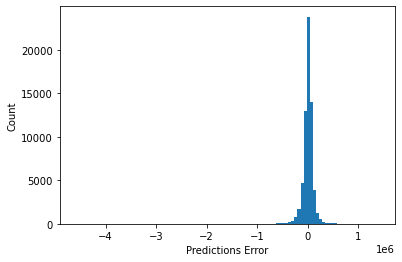

In [174]:
# Test error of the model
error = test_predictions - y_train
plt.hist(error, bins=100)
plt.xlabel("Predictions Error")
_ = plt.ylabel("Count")

In [270]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_predictions1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_predictions1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_predictions1)))

Mean Absolute Error: 68729.86994846707
Mean Squared Error: 15581730104.88982
Root Mean Squared Error: 124826.80042719119


In [238]:
#R2 score for the neural network model

r2 = r2_score(y_train.values.ravel(), test_predictions)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.77


In [162]:
# save the above simple nn fitted model to look at it later. We need to use the keras save command
# this command will save all the components of the model, in particular the architecture and the weights
# note: it will NOT save the training history. This needs to be saved separately.
NN_model.save('../dataset/simple_nn_model')

print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(NN_model.history.history, handle)

INFO:tensorflow:Assets written to: ../dataset/simple_nn_model/assets
Storing the fitting history of simple nn to disk


In [239]:
# we can load the above save model like this:
#simple_nn = keras.models.load_model("../dataset/simple_nn_model")
#simple_nn

# reload the fitting history like this
#with open("../dataset/simplen_nn_history.json", "r") as handle:
    #simple_nn_history = json.load(handle)

# Hypertuning batches, epochs and layers

In [240]:
from keras.wrappers.scikit_learn import KerasClassifier


In [255]:
from tensorflow.keras import layers
def build_NN_model():
    NN_model = Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    NN_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'accuracy'])
    return NN_model

In [256]:
# function that creates the model
# note that we pass the number of neurons as a parameter to the network
def create_model(neurons=1):
    nn_model = Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(X_train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    NN_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'accuracy'])

    return nn_model

seed = 1234
np.random.seed(seed)

# turn the keras model into a sklearn compatible model
# note that the neurons parameter needs to be specified in the interface of KerasClassifier
nn_model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [257]:
# define the grid search parameters
batch_size = [10, 20,30,40,50]
epochs = [100, 150,200,250,300,350,400]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [258]:
params_grid

{'batch_size': [10, 20, 30, 40, 50],
 'epochs': [100, 150, 200, 250, 300, 350, 400],
 'neurons': [10, 20, 30]}

In [262]:
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [263]:
#perform grid search with sklearn if needed, otherwise load the grid search already performed
if os.path.exists("../dataset/nn_grid_search.pickle") and USE_STORED_NN_HYPERTUNED_MODELS is True:
    with open('../dataset/nn_grid_search.pickle', 'rb') as handle:
        grid_search_nn = pickle.load(handle)
else:
    start_time = datetime.datetime.now()
    grid_search_nn = GridSearchCV(estimator=nn_model, param_grid=params_grid, n_jobs=-1)
    grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')
    # store the results of the grid search to disk
with open('../dataset/nn_grid_search.pickle', 'wb') as handle:
    pickle.dump(grid_search_nn, handle)

INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpw32ayax9/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmp5yi82etx/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpi5uydzpy/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpz6n4ryns/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpgdmwtozm/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmplk85ofvt/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmp2zws34ht/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpwzdrvd6i/assets
INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmp8i0w1rvf/assets
INFO:tensorflow:Ass

KeyboardInterrupt: 

INFO:tensorflow:Assets written to: ram:///var/folders/qv/1k6qmcy907d2pn7ks8rsk4kh0000gp/T/tmpzpez5m3g/assets


In [260]:
grid_search_nn

GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f846f32a190>,
             n_jobs=-1,
             param_grid={'batch_size': [10, 20, 30, 40, 50],
                         'epochs': [100, 150, 200, 250, 300, 350, 400],
                         'neurons': [10, 20, 30]})

In [268]:
print("The best parameter combination is: {} with score: {}".format(grid_search_nn.best_params_, grid_search_nn.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## Conclusion

Both models have good R2 scores which means that they are both accurate. After hypertuning the models the R2 score does not change much or at all. However, hypertuning was not needed to get a relevant R2 score to confirm the accuracy for predicting the houseprices. If we compare the R2 scored the Neural Network model gives a better accuracy than the Random Forest model. However, if we use the test_set the accuracy for the Random_Forest model is higher. 

The Mean Absolute Error of the predictions of the Neural Network model is lower than the predictions of the Random Forest model. Which means that the Neural Network model gives beter predictions with less error. 

In order to improve the accuracy of the models we should focus more on hypertuning the models or increase the amount of observations in the dataset or maybe add more features. 